# with PV 데이터
## 접속반내부 온도 --> 단자온도

In [1]:
from numpy import array
from numpy import hstack
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers.merge import concatenate
import pandas as pd
import numpy as np

In [2]:
import matplotlib.pyplot as plt

from matplotlib import font_manager, rc
font_path = "C:/Windows/Fonts/gulim.ttc"
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)

# DataFrame의 값 Line Chart 그리기
def plotData(df, columns = None, legend=None, type=None, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b'], 
             title=None, ylabel='Load', xlabel='Date-Hour', ylim=None, figsize=(11,3), saveto=None):
    fig = plt.figure(figsize=figsize)
    if ylim != None :
        plt.ylim(ylim[0], ylim[1])
        
    for i, col in enumerate(columns) :
        plt.plot(df[col], linewidth=1, color=color[i])
        
    # plt.grid(True, color='#f2f5f3', linestyle='-', linewidth=1)
    plt.grid(True, axis='y', color='#f2f5f3', alpha=0.5, linestyle='--')
    plt.grid(True, axis='x', color='#f2f5f3', alpha=0.5, linestyle='--')
    if title != None :
        plt.title(title, fontsize=14)
    plt.ylabel(ylabel, fontsize=12, labelpad=13) ; 
    plt.xlabel(xlabel, fontsize=12, labelpad=8)
    if legend == None :
        legend = columns
    _legend = plt.legend(legend, prop={'size': 13})
    _legend.get_frame().set_alpha(None)
    _legend.get_frame().set_facecolor((0, 0, 1, 0.1))
    plt.autoscale(enable=True, axis='x', tight=True)
    #     plt.axhline(y=10.0, color='r', linewidth=2)
    # plt.axhline(y=9.8, linewidth=2, color='#ff0000')
    #     plt.axvline(x=datetime(2019, 1, 1), color='r', linestyle=':', linewidth=1)
    if saveto != None :
        #plt.close(fig)
        plt.savefig(saveto)
    else :
        plt.show()

# plotData(df_day, columns=['diff1', 'pre1', 'pred1'], 
#          ylabel='Load', xlabel='Date-Hour', ylim=None, figsize=(11,3))

In [3]:
import pandas as pd
import numpy as np

## 전처리 프로그램

In [78]:
from numpy import array
from numpy import hstack
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers.merge import concatenate
import pandas as pd
import numpy as np

#--------------------------------------------------------- raw.csv 파일 Loading
filename ='raw.csv'
df0 = pd.read_csv(filename, encoding='euckr')
df0['일자'] = pd.to_datetime(df0['일자'])


#--------------------------------------------------------- 필요 Column 추출
df = df0.copy()
df = df[['일자', '외기온도', '모듈온도', '일사량', '접속반내부', '단자01', '단자02', '단자03', '단자04', '전체전류' ]]


#--------------------------------------------------------- 이상 데이터 Filtering
df['단자01'] = np.where(df['단자01'] > 100, np.nan, df['단자01'])
df['단자01'] = np.where(df['단자01'] < 5,   np.nan, df['단자01'])
df['단자02'] = np.where(df['단자02'] > 100, np.nan, df['단자02'])
df['단자02'] = np.where(df['단자02'] < 5,   np.nan, df['단자02'])
df['단자03'] = np.where(df['단자03'] > 100, np.nan, df['단자03'])
df['단자03'] = np.where(df['단자03'] < 5,   np.nan, df['단자03'])
df['단자04'] = np.where(df['단자04'] > 100, np.nan, df['단자04'])
df['단자04'] = np.where(df['단자04'] < 5,   np.nan, df['단자04'])
df['외기온도'] = np.where(df['외기온도'] > 100, np.nan, df['외기온도'])
df['접속반내부'] = np.where(df['접속반내부'] > 100, np.nan, df['접속반내부'])
df['외기온도'] = np.where((df['외기온도'] == 0) & (df['모듈온도'] == 0) & (df['일사량'] == 0) , np.nan, df['외기온도'])



#--------------------------------------------------------- NaN 데이터 삭제
df.dropna(inplace=True)

#--------------------------------------------------------- 중복 데이터 제거
df.drop_duplicates(subset=['일자'], inplace=True)

#--------------------------------------------------------- 누락된 시간 데이터 채우기 <-- Resample()
df.set_index('일자', inplace=True)
df = df.resample('T').ffill()  # 1 분 단위 Resampling
df.fillna(method='bfill', inplace=True)

#--------------------------------------------------------- Meta Data 생성 : 단자온도 - 접속반내부온도
df['단자--내부01'] = df['단자01'] - df['접속반내부']
df['단자--내부02'] = df['단자02'] - df['접속반내부']
df['단자--내부03'] = df['단자03'] - df['접속반내부']
df['단자--내부04'] = df['단자04'] - df['접속반내부']


#--------------------------------------------------------- Meta Data 생성 : 단자 평균온도 - 단자온도
def diffToMean(df, terminal):
    df[f'주변단자-평균{terminal:02}'] = 0
    _count = 0
    for t in range(1, 5):
        if t != terminal :
            df[f'주변단자-평균{terminal:02}'] += df[f'단자{t:02}']
            _count += 1
    df[f'주변단자-평균{terminal:02}'] = np.round(df[f'주변단자-평균{terminal:02}'] / _count, 2)
    df[f'단자-평균{terminal:02}'] = df[f'단자{terminal:02}'] - df[f'주변단자-평균{terminal:02}']

# df1 = df.copy()
diffToMean(df, 1)
diffToMean(df, 2)
diffToMean(df, 3)
diffToMean(df, 4)

#--------------------------------------------------------- Meta Data 생성 : Minutes/day 값 생성
df.reset_index(inplace=True)
df['day_minutes'] = df['일자'].dt.hour * 60 + df['일자'].dt.minute
df.set_index('일자', inplace=True)

# plotData(df, columns=['단자-평균01', '단자-평균02', '단자-평균03', '단자-평균04'], ylabel='Value', figsize=(14,3), ylim=(-10,20), title="단자온도 - 모듈 평균 단자온도")

#--------------------------------------------------------- 전처리 데이터 저장 to pre.csv
df.to_csv("pre.csv", encoding='euckr')

# df

In [79]:
df

,외기온도,모듈온도,일사량,접속반내부,단자01,단자02,단자03,단자04,전체전류,단자--내부01,...,단자--내부04,주변단자-평균01,단자-평균01,주변단자-평균02,단자-평균02,주변단자-평균03,단자-평균03,주변단자-평균04,단자-평균04,day_minutes
일자,,,,,,,,,,,,,,,,,,,,,
2021-04-09 09:53:00,24.5,30.3,691.0,28.0,30.0,30.0,30.0,30.0,36.5,2.0,...,2.0,30.0,0.0,30.00,0.00,30.00,0.00,30.00,0.00,593
2021-04-09 09:54:00,24.5,30.3,691.0,28.0,30.0,30.0,30.0,30.0,36.5,2.0,...,2.0,30.0,0.0,30.00,0.00,30.00,0.00,30.00,0.00,594
2021-04-09 09:55:00,25.2,31.3,700.5,28.0,30.0,30.0,30.0,30.0,37.1,2.0,...,2.0,30.0,0.0,30.00,0.00,30.00,0.00,30.00,0.00,595
2021-04-09 09:56:00,25.4,30.9,703.3,27.0,30.0,30.0,30.0,30.0,36.1,3.0,...,3.0,30.0,0.0,30.00,0.00,30.00,0.00,30.00,0.00,596
2021-04-09 09:57:00,25.4,30.9,703.3,27.0,30.0,30.0,30.0,30.0,36.1,3.0,...,3.0,30.0,0.0,30.00,0.00,30.00,0.00,30.00,0.00,597
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-05-31 23:55:00,22.2,13.2,0.0,29.0,28.0,29.0,29.0,29.0,0.9,-1.0,...,0.0,29.0,-1.0,28.67,0.33,28.67,0.33,28.67,0.33,1435
2021-05-31 23:56:00,22.2,13.2,0.0,29.0,28.0,29.0,29.0,29.0,0.9,-1.0,...,0.0,29.0,-1.0,28.67,0.33,28.67,0.33,28.67,0.33,1436
2021-05-31 23:57:00,22.4,13.4,0.0,29.0,28.0,29.0,29.0,29.0,0.8,-1.0,...,0.0,29.0,-1.0,28.67,0.33,28.67,0.33,28.67,0.33,1437


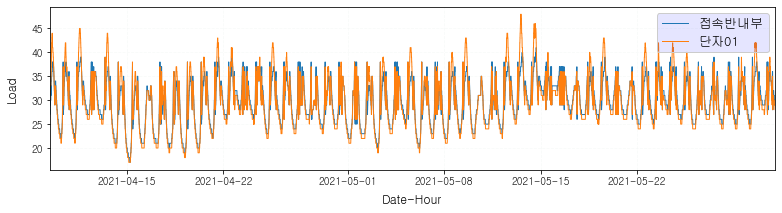

In [80]:
plotData(df, columns=['접속반내부', '단자01'], ylabel='Load', xlabel='Date-Hour', ylim=None, figsize=(13,3))

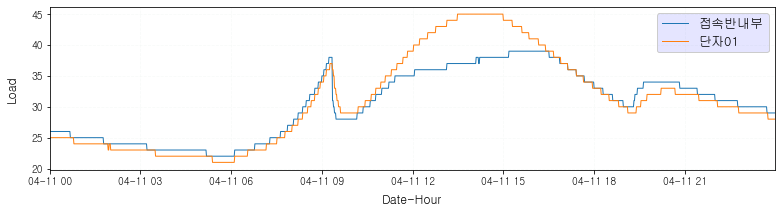

In [81]:
df1 = df['2021-04-11':'2021-04-11']
plotData(df1, columns=['접속반내부', '단자01'], ylabel='Load', xlabel='Date-Hour', ylim=None, figsize=(13,3))

## Training

In [97]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.callbacks import EarlyStopping

#----------------------------------------------- 2차원 Array를 1차원 Array로 Flatten
def flatten(lst_2d) :
    result = []
    for item in lst_2d:
        result.extend(item)
    return result

#----------------------------------------------- 학습 데이터 X, Y 준비
def prepareTrainXY_0(df, _col_X=['접속반내부'], _col_Y=['단자01'], steps=3, i_from="2021-04-10", i_to="2021-04-30"):
    if i_from != "" or i_to != "" :
        df1 = df[i_from:i_to]
    else :
        df1 = df
    dfx = df1[_col_X]
    dfy = df1[_col_Y]
    
    X = list()
    Y = list()
    for i in range(steps, len(dfx)):
        arr = dfx[i - steps:i].values
        X.append(flatten(arr))
        #print(flatten(arr))

    for i in range(steps, len(dfy)):
        arr = dfy[i - steps:i].values
        Y.append(flatten(arr))
    return np.array(X), np.array(Y)

#----------------------------------------------- 학습 데이터 X, Y 준비
def prepareTrainXY(df, _col_X=['접속반내부'], _col_Y=['단자01'], steps=3, i_from="2021-04-10", i_to="2021-04-30"):
    if i_from != "" or i_to != "" :
        df1 = df[i_from:i_to]
    else :
        df1 = df
    dfx = df1[_col_X]
    dfy = df1[_col_Y]
    
    X = list()
    Y = list()
    for i in range(steps, len(dfx)):
        x = dfx[i - steps:i].values
        X.append(flatten(x))
        #print(flatten(arr))
    if len(_col_X) == 1  and steps == 1:
        X = flatten(X)

    for i in range(steps, len(dfy)):
        y = dfy.iloc[i].values
        Y.append(y)

    if len(_col_Y) == 1:
        Y = flatten(Y)

    return np.array(X), np.array(Y)

#---------------------------------------------------------------------- 학습 History Plot
def drawHistory(history):
    ## summarize history for loss
    plt.figure(figsize=(14,4))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
#     plt.plot(history.history['mae'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['loss', 'val_loss'], loc='upper left')
    plt.show()    
    return
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

#---------------------------------------------------------------------- 모델 생성
def createModel(steps=1, input_dim=1, loss='msle', optimizer='adam', metrics=['accuracy']):
    print(f'input_dim = {input_dim}')
    model = keras.Sequential()

    # input layer
    model.add(Dense(100, input_dim=input_dim, kernel_initializer='uniform', activation='relu'))
    # hidden layer
#     model.add(Dense(100, kernel_initializer='uniform', activation='relu'))
    # output layer 
    model.add(Dense(1, kernel_initializer='uniform', activation='sigmoid'))
#     model.add(Dense(steps))
    ## Compile model
    model.compile(loss=loss, optimizer=optimizer, metrics=metrics) # binary_crossentropy
    return model

#---------------------------------------------------------------------- 모델 생성
def createModelMLP(input_dim=1, loss='mse', optimizer='adam', metrics=['accuracy']):
    model = keras.Sequential()

    model.add(Dense(10, activation="relu", input_dim=input_dim)) # input_shape=[input_dim])) # input_dim=input_dim)) # 
    # model.add(Dense(64, activation="relu"))
    model.add(Dense(1))
    model.compile(loss=loss, optimizer=optimizer, metrics=metrics) # binary_crossentropy
    return model

#---------------------------------------------------------------------- 모델 학습하기
def fitModel(model, X, Y, v_split=0.2, epochs=50, batch_size=50, f_callback = True, es_monitor='val_accuracy', es_patience=20):
    if f_callback :
        es = EarlyStopping(monitor=es_monitor, mode='auto', verbose=1, patience=es_patience)  # to overcome over-fitting
                                                                                  # 매 batch마다 Update --> Loss 계산 변화 점검
                                                                                  # epoch당 600번 update 중 100번 동안 변화 없으면 중지
        history = model.fit(X, Y, validation_split=v_split, epochs=epochs, batch_size=batch_size, verbose=1, callbacks=[es])
    else :
        history = model.fit(X, Y, validation_split=v_split, epochs=epochs, batch_size=batch_size, verbose=2)
    drawHistory(history)
    return history
    


In [112]:
#---------------------------------------------------------------------- Training Data 생성
n_steps = 5
col_X=['접속반내부', 'day_minutes']
col_Y=['단자01']

X, Y = prepareTrainXY(df, _col_X=col_X, _col_Y=col_Y, steps=n_steps,  i_from="2021-04-10", i_to="2021-04-30")

In [99]:
#---------------------------------------------------------------------- Model 생성 
input_d =n_steps*len(col_X)
model = createModelMLP(input_dim =input_d, loss='mse', metrics=['mae', 'msle'])

#---------------------------------------------------------------------- Model 로딩
# model = load_model('t_temp.h5')   #------------ 신규 생성 혹은 기존 모델 Loading --> Retraining



Epoch 1/50
484/484 [==============================] - 1s 1ms/step - loss: 84.3784 - mae: 4.3135 - msle: 0.1938 - val_loss: 18.3538 - val_mae: 1.2549 - val_msle: 0.0242
Epoch 2/50
484/484 [==============================] - 1s 1ms/step - loss: 13.7286 - mae: 1.5401 - msle: 0.0241 - val_loss: 7.1753 - val_mae: 0.9556 - val_msle: 0.0140
Epoch 3/50
484/484 [==============================] - 1s 1ms/step - loss: 7.5737 - mae: 1.4393 - msle: 0.0112 - val_loss: 4.3724 - val_mae: 1.1041 - val_msle: 0.0090
Epoch 4/50
484/484 [==============================] - 1s 1ms/step - loss: 5.5091 - mae: 1.3973 - msle: 0.0100 - val_loss: 2.8241 - val_mae: 0.8681 - val_msle: 0.0084
Epoch 5/50
484/484 [==============================] - 1s 1ms/step - loss: 4.7036 - mae: 1.4021 - msle: 0.0100 - val_loss: 2.4877 - val_mae: 1.0492 - val_msle: 0.0087
Epoch 6/50
484/484 [==============================] - 1s 1ms/step - loss: 4.1558 - mae: 1.3781 - msle: 0.0099 - val_loss: 3.6788 - val_mae: 1.5712 - val_msle: 0.0104
E

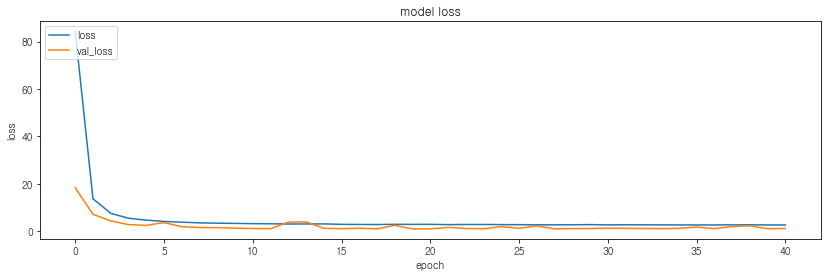

In [100]:
#---------------------------------------------------------------------- Training 
history = fitModel(model, X, Y, epochs=50, batch_size=50, es_monitor='loss', es_patience=5)

#---------------------------------------------------------------------- Model 저장 
model.save('t_temp.h5')


In [101]:
len(X)

30235

In [117]:
df1 = df["2021-04-10":"2021-04-30"][n_steps:]
len(df1)

30235

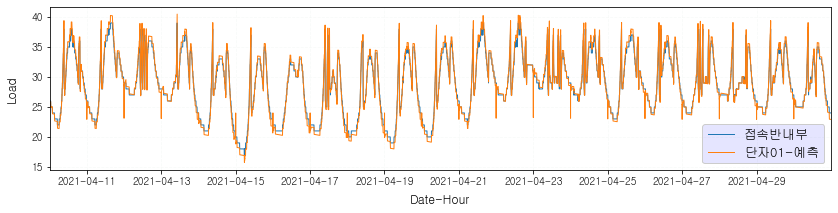

In [118]:

df1['단자01-예측'] = model.predict(X)
plotData(df1, columns=['접속반내부', '단자01-예측'], ylabel='Load', xlabel='Date-Hour', ylim=None, figsize=(14,3))

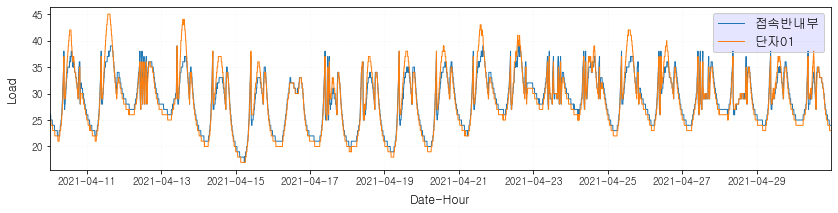

In [119]:
plotData(df1, columns=['접속반내부', '단자01'], ylabel='Load', xlabel='Date-Hour', ylim=None, figsize=(14,3))

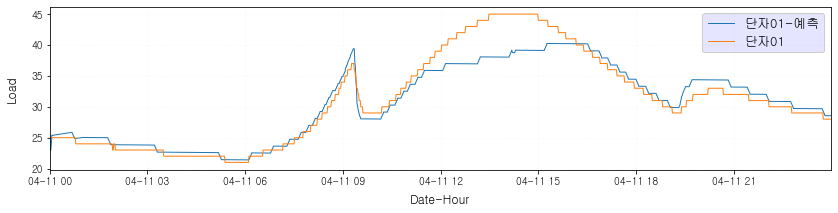

In [120]:
df1 = df1["2021-04-11":"2021-04-11"]
plotData(df1, columns=['단자01-예측', '단자01'], ylabel='Load', xlabel='Date-Hour', ylim=None, figsize=(14,3))

In [121]:
loss, mae, mse = model.evaluate(X, Y, verbose=2)

print("테스트 세트의 평균 절대 오차: {:5.2f}".format(mae))

945/945 - 1s - loss: 2.1907 - mae: 1.0610 - msle: 0.0019
테스트 세트의 평균 절대 오차:  1.06


In [122]:
#---------------------------------------------------------------------- Training Data 생성
n_steps = 5

X, Y = prepareTrainXY(df, _col_X=col_X, _col_Y=col_Y, steps=n_steps,  i_from="2021-05-01", i_to="2021-05-30")


In [123]:
loss, mae, mse = model.evaluate(X, Y, verbose=2)

print("테스트 세트의 평균 절대 오차: {:5.2f}".format(mae))

1350/1350 - 1s - loss: 3.0394 - mae: 1.2653 - msle: 0.0024
테스트 세트의 평균 절대 오차:  1.27
